# SANGU & NKU

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="http://sangu.edu.ge">
    <img height="80pt" src="https://sangu.edu.ge/img/logo.png"/><br/><center>SANGU</center></a>
  </td>
  <td>
    <a target="_blank" href="NKU">
    <img height="80pt" src="https://inside.nku.edu/content/inside/adminfinance/university-standing-committees/_jcr_content/par/columncontrol/column-2/textimage/image.img.png/1319033349.jpg" /><br/><center>NKU</center></a>
  </td>
</table>

#Graduate Program - Cybersecurity

##Learning Course - Machine Learning for Cybersecurity
#### Associate Professor, Dr. Paata Gogishvili

# Convolutional Neural Network (CNN)

This sample program demonstrates training a simple [Convolutional Neural Network](https://developers.google.com/machine-learning/glossary/#convolutional_neural_network) (CNN) to classify [CIFAR images](https://www.cs.toronto.edu/~kriz/cifar.html). Because this sample uses the [Keras Sequential API](https://www.tensorflow.org/guide/keras/overview), creating and training your model will take just a few lines of code.


### Import TensorFlow
Make sure, that it is installed, use <code>pip install tensorflow</code> if it is not

In [64]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np


### Download and prepare the CIFAR10 dataset


The CIFAR10 dataset contains 60,000 color images in 10 classes, with 6,000 images in each class. The dataset is divided into 50,000 training images and 10,000 testing images. The classes are mutually exclusive and there is no overlap between them.

In [66]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0
new_image = Image.open('bird.png').convert('RGB').resize((32, 32))
new_image = np.array(new_image) / 255.0  # Normalize the image
# Add the new image to the training dataset
new_image = new_image.reshape((1, 32, 32, 3))  # Reshape for the model input
new_label = np.array([[2]])  # Assuming 'bird' class index is 2
train_images = np.concatenate([train_images, new_image])
train_labels = np.concatenate([train_labels, new_label])


### Verify the data

To verify that the dataset looks correct, let's plot the first 25 images from the training set and display the class name below each image:


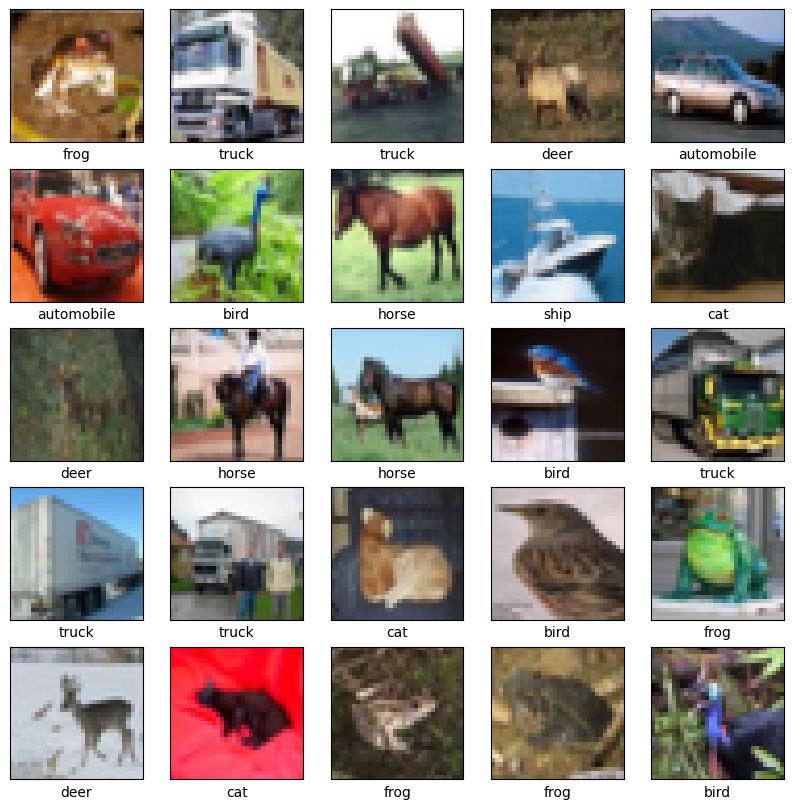

In [67]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays,
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
    #plt.xlabel(train_labels[i][0])

plt.show()

### Create the convolutional base

The 6 lines of code below define the convolutional base using a common pattern: a stack of [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) and [MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) layers.

As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size. If you are new to these dimensions, color_channels refers to (R,G,B). In this example, you will configure your CNN to process inputs of shape (32, 32, 3), which is the format of CIFAR images. You can do this by passing the argument `input_shape` to your first layer.


In [68]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

Let's display the architecture of your model so far:

In [69]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 4, 4, 64)       │        36,928 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,320 (220.00 KB)

 Trainable params: 56,320 (220.00 KB)

 Non-trainable params: 0 (0.00 B)

Above, you can see that the output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). The width and height dimensions tend to shrink as you go deeper in the network. The number of output channels for each Conv2D layer is controlled by the first argument (e.g., 32 or 64). Typically,  as the width and height shrink, you can afford (computationally) to add more output channels in each Conv2D layer.

### Add Dense layers on top

To complete the model, you will feed the last output tensor from the convolutional base (of shape (4, 4, 64)) into one or more Dense layers to perform classification. Dense layers take vectors as input (which are 1D), while the current output is a 3D tensor. First, you will flatten (or unroll) the 3D output to 1D,  then add one or more Dense layers on top. CIFAR has 10 output classes, so you use a final Dense layer with 10 outputs.

In [70]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

Here's the complete architecture of your model:

In [71]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,570 (478.79 KB)

 Trainable params: 122,570 (478.79 KB)

 Non-trainable params: 0 (0.00 B)

The network summary shows that (4, 4, 64) outputs were flattened into vectors of shape (1024) before going through two Dense layers.

### Compile and train the model

In [72]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10,
                    validation_data=(test_images, test_labels))

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.3174 - loss: 1.8278 - val_accuracy: 0.5496 - val_loss: 1.2584
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5694 - loss: 1.2136 - val_accuracy: 0.6145 - val_loss: 1.1071
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6344 - loss: 1.0335 - val_accuracy: 0.6655 - val_loss: 0.9703
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6721 - loss: 0.9276 - val_accuracy: 0.6571 - val_loss: 0.9636
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7044 - loss: 0.8412 - val_accuracy: 0.6794 - val_loss: 0.9090
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7270 - loss: 0.7783 - val_accuracy: 0.7007 - val_loss: 0.8574
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7446 - loss: 0.7234 - val_accuracy: 0.6982 - val_loss: 0.8657
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7605 - loss: 0.6851 - 

### Evaluate the model

313/313 - 0s - 1ms/step - accuracy: 0.7005 - loss: 0.8872


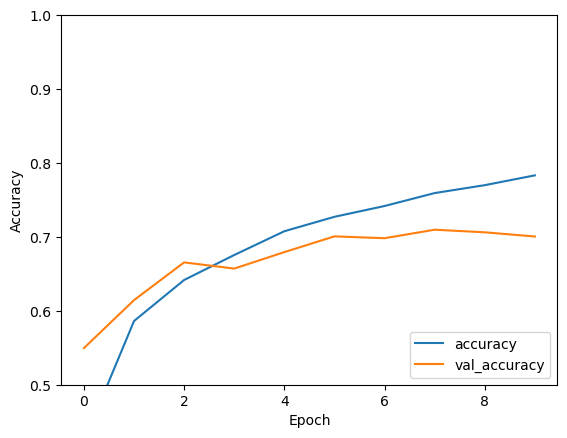

In [73]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [74]:
print(test_acc)

0.7005000114440918


This simple CNN has achieved a test accuracy of over 70%. Not bad for a few lines of code!

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Predicted class: [2]


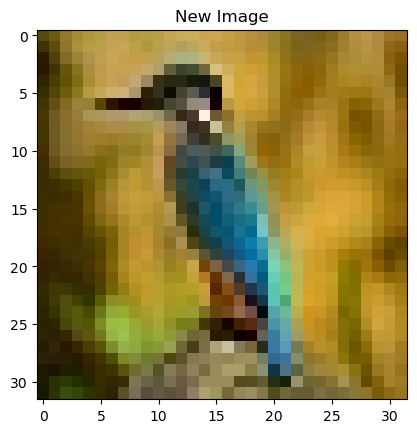

In [75]:
# Make a prediction
predictions = model.predict(new_image)
predicted_class = np.argmax(predictions, axis=1)
print("Predicted class:", predicted_class)

# Optionally, visualize the new image
plt.imshow(new_image[0])
plt.title('New Image')
plt.show()


Predicted class: [2] : 2 is for bird